In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import csv
import os
import math 
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

from tqdm.notebook import tqdm
from ipywidgets import interact

from skimage.transform import resize

In [ ]:
# Dataset Paths
dataset_path = r"/content/gdrive/Shareddrives/Tugas Akhir/Dataset"

json_refuge_path = os.path.join(dataset_path, 'df_refugetrain.json')
json_refugeval_path = os.path.join(dataset_path, 'df_refugeval.json')
json_refugetest_path = os.path.join(dataset_path, 'df_refugetest.json')
json_drishti_path = os.path.join(dataset_path, 'df_drishti.json')

json_local_path = os.path.join(dataset_path, 'df_local_crop.json')
json_result_path = os.path.join(dataset_path, 'df_result_dis2.json')
json_feature_norm = os.path.join(dataset_path, 'df_feature_norm.json')
json_feature_axes = os.path.join(dataset_path, 'df_feature_axes.json')
json_feature_rim = os.path.join(dataset_path, 'df_feature_rim.json')

In [ ]:
df = pd.read_json(json_result_path)
df = df.reset_index(drop=True)
df.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge test   Glaucoma     40
              Normal      360
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     38
              Normal      360
dtype: int64

# Functions

In [ ]:
def MeanScore(Fscore):
  mean = np.mean(Fscore)
  std = np.std(Fscore)
  print('{:.3f} +- {:.3f}'.format(mean, std))

In [ ]:
def saving_image(img, path):
  if os.path.isfile(path):
    os.remove(path)
    cv2.imwrite(path, img)
  else:
    cv2.imwrite(path, img)

## Feature Extraction with Axes

In [ ]:
def CDRcalc(OD_feat, OC_feat):
  VCDR = float(OC_feat[0]) / float(OD_feat[0]) # vertical CDR
  HCDR = float(OC_feat[1]) / float(OD_feat[1]) # Horizontal CDR
  ACDR = float(OC_feat[2]) / float(OD_feat[2]) # Area CDR

  return VCDR, HCDR, ACDR

In [ ]:
def getFeature(mask):
  cont, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  cont = cv2.approxPolyDP(cont[0], 3, True)
  _, _, hor, ver = cv2.boundingRect(cont)
  area = np.sum(mask == 255)

  return ver, hor, area

In [ ]:
def getCenter(mask):
  M = cv2.moments(mask)
  center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

  return center

In [ ]:
def getODAxes(mask):
  c_OD, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  ellipse = cv2.fitEllipse(c_OD[0])
  center, (hor, ver), angle = ellipse
  area = np.sum(mask == 255)
  
  if (angle > 45) and (angle <= 135):
    angle -= 90
    temp = hor
    hor = ver
    ver = temp

  elif (angle > 135) and (angle <= 180):
    angle -= 180

  return center, (ver, hor, area), angle

In [ ]:
def getOCAxes(mask, angle):
  center = getCenter(mask)
  rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
  mask = cv2.warpAffine(mask, rot_mat, mask.shape[1::-1], flags=cv2.INTER_LINEAR)
  feat = getFeature(mask)

  return center, feat, angle

## Feature Extraction RDR

In [ ]:
def ekstrakROI(centroid, s, img):

  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = math.floor(x - 0.5*s)
  x1 = math.floor(x + 0.5*s)
  y0 = math.floor(y - 0.5*s)
  y1 = math.floor(y + 0.5*s)

  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0

  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0

  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)

  return y0, y1, x0, x1

In [ ]:
def getCartesian(r, angle, center, width):
  x1 = float(r) * math.cos(angle) + center[0]
  y1 = float(r) * math.sin(angle) + center[1]
  x2 = float(r + width) * math.cos(angle) + center[0]
  y2 = float(r + width) * math.sin(angle) + center[1]

  return (x1, x2), (y1, y2)

In [ ]:
def polarTransform(mask, center, shape):
  mask, _ = ekstrakROI(center, shape, mask)
  mask = cv2.linearPolar(mask, (mask.shape[0]/2, mask.shape[1]/2), shape, cv2.WARP_FILL_OUTLIERS)
  
  return mask

In [ ]:
def getRim(polarOD, polarOC):
  polarRim = cv2.subtract(polarOD, polarOC)
  min = polarRim.shape[1]
  ind = 0

  for i in range(polarOD.shape[1]):
    temp = np.sum(polarRim[i] > 127)
    if temp < min and min >= 0:
      min = temp
      ind = i

  r = (np.sum(polarOC[ind] > 127), np.sum(polarOD[ind] > 127))
  a = float(ind)/float(polarOD.shape[0]) * 2 * math.pi

  return min, r, a

# Feature Extraction (Kak Nafis)

In [ ]:
VCDR = []
HCDR = []
ACDR = []
centerOD = []
centerOC = []
featOD = []
featOC = []

angle = [0]*len(df)

for i in tqdm(range(len(df))):
  OD_fit = cv2.imread(df['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df['path_OC_fixed'].iloc[i], 0)
  
  centerOD.append(getCenter(OD_fit))
  centerOC.append(getCenter(OC_fit))

  featOD.append(getFeature(OD_fit))
  featOC.append(getFeature(OC_fit))

  V, H, A = CDRcalc(featOD[-1], featOC[-1])
  VCDR.append(V)
  HCDR.append(H)
  ACDR.append(A)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
VCDR_gt = []
HCDR_gt = []
ACDR_gt = []
centerOD_gt = []
centerOC_gt = []
featOD_gt = []
featOC_gt = []

angle_gt = [0]*len(df)

for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_loc'].iloc[i], 0)
  OC_gt = cv2.imread(df['path_OC_loc'].iloc[i], 0)

  centerOD_gt.append(getCenter(OD_gt))
  centerOC_gt.append(getCenter(OC_gt))

  featOD_gt.append(getFeature(OD_gt))
  featOC_gt.append(getFeature(OC_gt))

  V, H, A = CDRcalc(featOD_gt[-1], featOC_gt[-1])
  VCDR_gt.append(V)
  HCDR_gt.append(H)
  ACDR_gt.append(A)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
VCDR_mae = []
HCDR_mae = []
ACDR_mae = []
VCDR_err = []
HCDR_err = []
ACDR_err = []

for i in range(len(df)):
  VCDR_err.append(VCDR[i] - VCDR_gt[i])
  HCDR_err.append(HCDR[i] - HCDR_gt[i])
  ACDR_err.append(ACDR[i] - ACDR_gt[i])
  VCDR_mae.append(abs(VCDR_err[-1]))
  HCDR_mae.append(abs(HCDR_err[-1]))
  ACDR_mae.append(abs(ACDR_err[-1]))

In [ ]:
MeanScore(VCDR_err)
MeanScore(HCDR_err)
MeanScore(ACDR_err)

0.003 +- 0.048
0.009 +- 0.058
0.009 +- 0.044


In [ ]:
print(max(VCDR_mae))
print(max(HCDR_mae))
print(max(ACDR_mae))

0.2263126000952257
0.44565217391304346
0.2535864104019389


In [ ]:
df_feature_norm = pd.DataFrame({'file_name': df['file_name'], 'tag': df['tag'], 'path_img_loc': df['path_img_loc'], 'path_OD_loc': df['path_OD_loc'],
                          'path_OC_loc': df['path_OC_loc'], 'dataset': df['dataset'], "path_OD_fixed": df['path_OD_fixed'], "path_OC_fixed": df['path_OC_fixed'],
                          'Fscore_OD_fit': df['Fscore_OD_fit'], 'Fscore_OC_fit': df['Fscore_OC_fit'],
                          'VCDR': VCDR, 'HCDR': HCDR, 'ACDR': ACDR, 'centerOD': centerOD, 'centerOC': centerOC, 'featOD': featOD, 'featOC': featOC, 'angle':angle,
                          'VCDR_gt': VCDR_gt, 'HCDR_gt': HCDR_gt, 'ACDR_gt': ACDR_gt, 'centerOD_gt': centerOD_gt, 'centerOC_gt': centerOC_gt,
                          'featOD_gt': featOD_gt, 'featOC_gt': featOC_gt, 'angle_gt':angle_gt, 'VCDR_mae': VCDR_mae, 'HCDR_mae': HCDR_mae, 'ACDR_mae': ACDR_mae})

In [ ]:
df_feature_norm.head()

,file_name,tag,path_img_loc,path_OD_loc,path_OC_loc,dataset,path_OD_fixed,path_OC_fixed,Fscore_OD_fit,Fscore_OC_fit,...,HCDR_gt,ACDR_gt,centerOD_gt,centerOC_gt,featOD_gt,featOC_gt,angle_gt,VCDR_mae,HCDR_mae,ACDR_mae
0,drishtiGS_002.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.965762,0.963694,...,0.704467,0.552874,"(279, 277)","(278, 292)","(290, 291, 64767)","(219, 205, 35808)",0,0.023880,0.023111,0.054656
1,drishtiGS_004.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.980383,0.959161,...,0.811881,0.669649,"(316, 281)","(318, 290)","(321, 303, 77351)","(267, 246, 51798)",0,0.025367,0.003440,0.025018
2,drishtiGS_008.png,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.973390,0.907240,...,0.601286,0.344148,"(284, 284)","(290, 285)","(324, 311, 78286)","(188, 187, 26942)",0,0.063219,0.031750,0.049376
3,drishtiGS_010.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.978267,0.974240,...,0.862069,0.786769,"(290, 277)","(286, 284)","(361, 348, 96018)","(322, 300, 75544)",0,0.022563,0.012637,0.006552
4,drishtiGS_012.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.977389,0.954937,...,0.831615,0.734077,"(299, 278)","(300, 280)","(322, 291, 72931)","(281, 242, 53537)",0,0.049689,0.000534,0.031949


In [ ]:
if os.path.isfile(json_feature_norm):
  os.remove(json_feature_norm)
  df_feature_norm.to_json (json_feature_norm)
else:
  df_feature_norm.to_json (json_feature_norm)

# Feature Extraction with Axes

In [ ]:
VCDR = []
HCDR = []
ACDR = []
centerOD = []
centerOC = []
featOD = []
featOC = []
angle = []

for i in tqdm(range(len(df))):
  OD_fit = cv2.imread(df['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df['path_OC_fixed'].iloc[i], 0)
  
  c, f, a = getODAxes(OD_fit)
  centerOD.append(c)
  featOD.append(f)
  angle.append(a)

  c, f, a = getOCAxes(OC_fit, a)
  centerOC.append(c)
  featOC.append(f)

  V, H, A = CDRcalc(featOD[-1], featOC[-1])
  VCDR.append(V)
  HCDR.append(H)
  ACDR.append(A)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
VCDR_gt = []
HCDR_gt = []
ACDR_gt = []
centerOD_gt = []
centerOC_gt = []
featOD_gt = []
featOC_gt = []
angle_gt = []

for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_loc'].iloc[i], 0)
  OC_gt = cv2.imread(df['path_OC_loc'].iloc[i], 0)
  
  c, f, a = getODAxes(OD_gt)
  centerOD_gt.append(c)
  featOD_gt.append(f)
  angle_gt.append(a)

  c, f, a = getOCAxes(OC_gt, a)
  centerOC_gt.append(c)
  featOC_gt.append(f)

  V, H, A = CDRcalc(featOD_gt[-1], featOC_gt[-1])
  VCDR_gt.append(V)
  HCDR_gt.append(H)
  ACDR_gt.append(A)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
VCDR_mae = []
HCDR_mae = []
ACDR_mae = []
VCDR_err = []
HCDR_err = []
ACDR_err = []

for i in range(len(df)):
  VCDR_err.append(VCDR[i] - VCDR_gt[i])
  HCDR_err.append(HCDR[i] - HCDR_gt[i])
  ACDR_err.append(ACDR[i] - ACDR_gt[i])
  VCDR_mae.append(abs(VCDR_err[-1]))
  HCDR_mae.append(abs(HCDR_err[-1]))
  ACDR_mae.append(abs(ACDR_err[-1]))

In [ ]:
MeanScore(VCDR_err)
MeanScore(HCDR_err)
MeanScore(ACDR_err)

0.005 +- 0.047
0.006 +- 0.058
0.009 +- 0.044


In [ ]:
print(max(VCDR_mae))
print(max(HCDR_mae))
print(max(ACDR_mae))

0.24642017420733264
0.4626394124078347
0.2521283208971447


In [ ]:
df_feature_axes = pd.DataFrame({'file_name': df['file_name'], 'tag': df['tag'], 'path_img_loc': df['path_img_loc'], 'path_OD_loc': df['path_OD_loc'],
                          'path_OC_loc': df['path_OC_loc'], 'dataset': df['dataset'], "path_OD_fixed": df['path_OD_fixed'], "path_OC_fixed": df['path_OC_fixed'],
                          'Fscore_OD_fit': df['Fscore_OD_fit'], 'Fscore_OC_fit': df['Fscore_OC_fit'],
                          'VCDR': VCDR, 'HCDR': HCDR, 'ACDR': ACDR, 'centerOD': centerOD, 'centerOC': centerOC, 'featOD': featOD, 'featOC': featOC, 'angle':angle,
                          'VCDR_gt': VCDR_gt, 'HCDR_gt': HCDR_gt, 'ACDR_gt': ACDR_gt, 'centerOD_gt': centerOD_gt, 'centerOC_gt': centerOC_gt,
                          'featOD_gt': featOD_gt, 'featOC_gt': featOC_gt, 'angle_gt':angle_gt, 'VCDR_mae': VCDR_mae, 'HCDR_mae': HCDR_mae, 'ACDR_mae': ACDR_mae})

In [ ]:
df_feature_axes.tail()

,file_name,tag,path_img_loc,path_OD_loc,path_OC_loc,dataset,path_OD_fixed,path_OC_fixed,Fscore_OD_fit,Fscore_OC_fit,...,HCDR_gt,ACDR_gt,centerOD_gt,centerOC_gt,featOD_gt,featOC_gt,angle_gt,VCDR_mae,HCDR_mae,ACDR_mae
1243,T0396.jpg,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,refuge test,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.931274,0.814763,...,0.428422,0.147497,"(276.0793762207031, 265.0646057128906)","(279, 265)","(269.88641357421875, 233.41452026367188, 48706)","(98, 100, 7184)",-0.948502,0.032716,0.024687,0.009412
1244,T0397.jpg,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,refuge test,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.935746,0.914526,...,0.756499,0.566936,"(270.1731872558594, 264.56866455078125)","(274, 263)","(279.2930908203125, 284.2040710449219, 61499)","(213, 215, 34866)",17.425720,0.073554,0.045272,0.088331
1245,T0398.jpg,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,refuge test,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.899782,0.717673,...,0.764649,0.424698,"(278.7162780761719, 275.7110290527344)","(280, 280)","(296.0003356933594, 210.55421447753906, 48206)","(176, 161, 20473)",13.761226,0.141276,0.134596,0.167641
1246,T0399.jpg,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,refuge test,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.953554,0.872614,...,0.466238,0.209983,"(281.3950500488281, 289.157958984375)","(314, 298)","(279.1767578125, 250.94459533691406, 54214)","(140, 117, 11384)",16.346052,0.009285,0.011908,0.001372
1247,T0400.jpg,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,refuge test,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.937389,0.777590,...,0.482221,0.172809,"(234.2755584716797, 266.2372131347656)","(260, 286)","(287.3495788574219, 215.66893005371094, 47949)","(115, 104, 8286)",3.003012,0.031822,0.051556,0.007491


In [ ]:
if os.path.isfile(json_feature_axes):
  os.remove(json_feature_axes)
  df_feature_axes.to_json (json_feature_axes)
else:
  df_feature_axes.to_json (json_feature_axes)

# Feature Extraction RDR

In [ ]:
widthRim = []
widthOD = []
radRim = []
radOD = []
centerOC = []
angle = []

for i in tqdm(range(len(df))):
  OD_fit = cv2.imread(df['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df['path_OC_fixed'].iloc[i], 0)

  cOC = getCenter(OC_fit)
  cOD = getCenter(OD_fit)
  ver, hor, area = getFeature(OD_fit)
  size = max(ver, hor) + max(abs(cOD[0] - cOC[0]), abs(cOD[1] - cOC[1]))
  polarOD = polarTransform(OD_fit, cOC, size)
  polarOC = polarTransform(OC_fit, cOC, size)
  rim_fit = cv2.subtract(OD_fit, OC_fit)

  rimWidth, r, a = getRim(polarOD, polarOC)
  a_deg = a * 180/math.pi

  ODcrop, _ = ekstrakROI(cOC, size, OD_fit)
  _, featOD, _ = getOCAxes(ODcrop, a_deg)

  rRim = getCartesian(r[0], a, cOC, rimWidth)
  rOD = getCartesian(r[1], a, cOC, featOD[1] * (-1))

  widthOD.append(featOD[1])
  widthRim.append(rimWidth)
  radRim.append(rRim)
  radOD.append(rOD)
  centerOC.append(cOC)
  angle.append(a_deg)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
widthRim_gt = []
widthOD_gt = []
radRim_gt = []
radOD_gt = []
centerOC_gt = []
angle_gt = []

for i in tqdm(range(len(df))):
  OD_fit = cv2.imread(df['path_OD_loc'].iloc[i], 0)
  OC_fit = cv2.imread(df['path_OC_loc'].iloc[i], 0)

  cOC = getCenter(OC_fit)
  cOD = getCenter(OD_fit)
  ver, hor, area = getFeature(OD_fit)
  size = max(ver, hor) + max(abs(cOD[0] - cOC[0]), abs(cOD[1] - cOC[1]))
  polarOD = polarTransform(OD_fit, cOC, size)
  polarOC = polarTransform(OC_fit, cOC, size)
  rim_fit = cv2.subtract(OD_fit, OC_fit)

  rimWidth, r, a = getRim(polarOD, polarOC)
  a_deg = a * 180/math.pi

  ODcrop, _ = ekstrakROI(cOC, size, OD_fit)
  _, featOD, _ = getOCAxes(ODcrop, a_deg)

  rRim = getCartesian(r[0], a, cOC, rimWidth)
  rOD = getCartesian(r[1], a, cOC, featOD[1] * (-1))

  widthOD_gt.append(featOD[1])
  widthRim_gt.append(rimWidth)
  radRim_gt.append(rRim)
  radOD_gt.append(rOD)
  centerOC_gt.append(cOC)
  angle_gt.append(a_deg)

  0%|          | 0/1248 [00:00<?, ?it/s]

In [ ]:
RDR = []
RDR_gt = []
RDR_mae = []
RDR_err = []

for i in range(len(df)):
  RDR.append(float(widthRim[i])/float(widthOD[i]))
  RDR_gt.append(float(widthRim_gt[i])/float(widthOD_gt[i]))
  RDR_err.append(RDR[-1] - RDR_gt[-1])
  RDR_mae.append(abs(RDR_err[-1]))

In [ ]:
MeanScore(RDR_err)
MeanScore(RDR_mae)

0.001 +- 0.043
0.031 +- 0.029


In [ ]:
df_feature_rim = pd.DataFrame({'file_name': df['file_name'], 'tag': df['tag'], 'path_img_loc': df['path_img_loc'], 'path_OD_loc': df['path_OD_loc'],
                               'path_OC_loc': df['path_OC_loc'], 'dataset': df['dataset'], "path_OD_fixed": df['path_OD_fixed'], "path_OC_fixed": df['path_OC_fixed'],
                               'Fscore_OD_fit': df['Fscore_OD_fit'], 'Fscore_OC_fit': df['Fscore_OC_fit'],
                               'centerOC': centerOC, 'radRim': radRim, 'radOD': radOD, 'angle':angle, 
                               'centerOC_gt': centerOC_gt, 'radRim_gt': radRim_gt, 'radOD_gt': radOD_gt, 'angle_gt':angle_gt,
                               'RDR': RDR, 'RDR_gt': RDR_gt, 'RDR_mae': RDR_mae
                               })

In [ ]:
df_feature_rim.head()

,file_name,tag,path_img_loc,path_OD_loc,path_OC_loc,dataset,path_OD_fixed,path_OC_fixed,Fscore_OD_fit,Fscore_OC_fit,...,radRim,radOD,angle,centerOC_gt,radRim_gt,radOD_gt,angle_gt,RDR,RDR_gt,RDR_mae
0,drishtiGS_002.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.965762,0.963694,...,"((260.94552372308505, 257.73462846770207), (40...","((257.73462846770207, 300.64386506236565), (42...",98.392283,"(278, 292)","((306.93972640549487, 311.001442392231), (402....","((311.001442392231, 237.12898288346776), (417....",75.294118,0.074830,0.054983,0.019847
1,drishtiGS_004.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.980383,0.959161,...,"((341.9077110014402, 344.0218882944105), (430....","((344.0218882944105, 282.13415299109806), (441...",78.918919,"(318, 290)","((293.354402759467, 290.4760848335653), (424.7...","((290.4760848335653, 349.1218125738117), (440....",100.363636,0.034161,0.049080,0.014918
2,drishtiGS_008.png,Normal,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.973390,0.907240,...,"((376.4158312402841, 436.01753435865953), (271...","((436.01753435865953, 134.03557189222371), (26...",353.394495,"(290, 285)","((383.38728312276373, 437.03529683158547), (29...","((437.03529683158547, 123.09506846144356), (30...",6.545455,0.197368,0.170886,0.026482
3,drishtiGS_010.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.978267,0.974240,...,"((242.17846952448582, 240.95766667934384), (43...","((240.95766667934384, 325.1930629941388), (443...",104.132231,"(286, 284)","((186.78708423632503, 182.27740624706706), (40...","((182.27740624706706, 404.54010714620904), (40...",130.108696,0.014493,0.020290,0.005797
4,drishtiGS_012.png,Glaucoma,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,/content/gdrive/Shareddrives/Tugas Akhir/Datas...,drishti,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,/content/gdrive/Shareddrives/Tugas Akhir/Code/...,0.977389,0.954937,...,"((339.8847246634512, 343.2807834199473), (420....","((343.2807834199473, 252.43621168367807), (432...",73.560372,"(300, 280)","((374.7332210176296, 383.5253646667625), (393....","((383.5253646667625, 213.17758146481265), (406...",56.666667,0.037383,0.051613,0.014230


In [ ]:
if os.path.isfile(json_feature_rim):
  os.remove(json_feature_rim)
  df_feature_rim.to_json(json_feature_rim)
else:
  df_feature_rim.to_json(json_feature_rim)

# Evaluasi

In [ ]:
df_feature_norm = pd.read_json(json_feature_norm)
df_feature_norm = df_feature_norm.reset_index(drop=True)
df_feature_norm.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge test   Glaucoma     40
              Normal      360
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     38
              Normal      360
dtype: int64

In [ ]:
df_feature_axes = pd.read_json(json_feature_axes)
df_feature_axes = df_feature_axes.reset_index(drop=True)
df_feature_axes.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge test   Glaucoma     40
              Normal      360
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     38
              Normal      360
dtype: int64

In [ ]:
df_feature_rim = pd.read_json(json_feature_rim)
df_feature_rim = df_feature_rim.reset_index(drop=True)
df_feature_rim.groupby(['dataset', 'tag']).size()

dataset       tag     
drishti       Glaucoma     32
              Normal       18
refuge test   Glaucoma     40
              Normal      360
refuge train  Glaucoma     40
              Normal      360
refuge val    Glaucoma     38
              Normal      360
dtype: int64

## Mean MAE

### Norm

In [ ]:
MeanScore(df_feature_norm['VCDR_mae'])
MeanScore(df_feature_norm['HCDR_mae'])
MeanScore(df_feature_norm['ACDR_mae'])

0.036 +- 0.032
0.044 +- 0.038
0.033 +- 0.031


In [ ]:
MeanScore(df_feature_norm['VCDR_mae'].loc[df_feature_norm['dataset'] == 'drishti'])
MeanScore(df_feature_norm['HCDR_mae'].loc[df_feature_norm['dataset'] == 'drishti'])
MeanScore(df_feature_norm['ACDR_mae'].loc[df_feature_norm['dataset'] == 'drishti'])

0.019 +- 0.015
0.026 +- 0.020
0.024 +- 0.016


In [ ]:
MeanScore(df_feature_norm['VCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge train'])
MeanScore(df_feature_norm['HCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge train'])
MeanScore(df_feature_norm['ACDR_mae'].loc[df_feature_norm['dataset'] == 'refuge train'])

0.030 +- 0.023
0.035 +- 0.028
0.027 +- 0.022


In [ ]:
MeanScore(df_feature_norm['VCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge val'])
MeanScore(df_feature_norm['HCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge val'])
MeanScore(df_feature_norm['ACDR_mae'].loc[df_feature_norm['dataset'] == 'refuge val']) 

0.033 +- 0.029
0.040 +- 0.033
0.028 +- 0.026


In [ ]:
MeanScore(df_feature_norm['VCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge test'])
MeanScore(df_feature_norm['HCDR_mae'].loc[df_feature_norm['dataset'] == 'refuge test'])
MeanScore(df_feature_norm['ACDR_mae'].loc[df_feature_norm['dataset'] == 'refuge test'])

0.048 +- 0.040
0.059 +- 0.048
0.046 +- 0.039


### Axes

In [ ]:
MeanScore(df_feature_axes['VCDR_mae'])
MeanScore(df_feature_axes['HCDR_mae'])
MeanScore(df_feature_axes['ACDR_mae'])
MeanScore(abs(df_feature_axes['angle'] - df_feature_axes['angle_gt']))
MeanScore(df_feature_axes['angle'])
MeanScore(df_feature_axes['angle_gt'])

0.036 +- 0.031
0.044 +- 0.039
0.033 +- 0.030
7.861 +- 10.058
0.556 +- 14.205
0.426 +- 10.317


In [ ]:
MeanScore(df_feature_axes['VCDR_mae'].loc[df_feature_axes['dataset'] == 'drishti'])
MeanScore(df_feature_axes['HCDR_mae'].loc[df_feature_axes['dataset'] == 'drishti'])
MeanScore(df_feature_axes['ACDR_mae'].loc[df_feature_axes['dataset'] == 'drishti'])
MeanScore(abs(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'drishti'] - df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'drishti']))
MeanScore(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'drishti'])
MeanScore(df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'drishti'])

0.018 +- 0.016
0.025 +- 0.019
0.024 +- 0.016
9.238 +- 14.524
5.380 +- 19.600
1.550 +- 17.460


In [ ]:
MeanScore(df_feature_axes['VCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge train'])
MeanScore(df_feature_axes['HCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge train'])
MeanScore(df_feature_axes['ACDR_mae'].loc[df_feature_axes['dataset'] == 'refuge train'])
MeanScore(abs(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge train'] - df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge train']))
MeanScore(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge train'])
MeanScore(df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge train'])

0.030 +- 0.023
0.035 +- 0.028
0.027 +- 0.022
7.163 +- 10.371
-0.638 +- 13.789
-0.647 +- 10.978


In [ ]:
MeanScore(df_feature_axes['VCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge val'])
MeanScore(df_feature_axes['HCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge val'])
MeanScore(df_feature_axes['ACDR_mae'].loc[df_feature_axes['dataset'] == 'refuge val'])
MeanScore(abs(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge val'] - df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge val']))
MeanScore(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge val'])
MeanScore(df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge val'])

0.034 +- 0.028
0.040 +- 0.033
0.028 +- 0.025
6.806 +- 9.074
-0.856 +- 12.312
0.071 +- 9.048


In [ ]:
MeanScore(df_feature_axes['VCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge test'])
MeanScore(df_feature_axes['HCDR_mae'].loc[df_feature_axes['dataset'] == 'refuge test'])
MeanScore(df_feature_axes['ACDR_mae'].loc[df_feature_axes['dataset'] == 'refuge test'])
MeanScore(abs(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge test'] - df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge test']))
MeanScore(df_feature_axes['angle'].loc[df_feature_axes['dataset'] == 'refuge test'])
MeanScore(df_feature_axes['angle_gt'].loc[df_feature_axes['dataset'] == 'refuge test'])

0.047 +- 0.039
0.058 +- 0.050
0.045 +- 0.039
9.435 +- 9.772
2.552 +- 15.175
1.711 +- 9.431


### Rim

In [ ]:
MeanScore(df_feature_rim['RDR_mae'])
MeanScore(abs(df_feature_rim['angle'] - df_feature_rim['angle_gt']))
MeanScore(df_feature_rim['angle'])
MeanScore(df_feature_rim['angle_gt'])

0.031 +- 0.029
108.105 +- 137.571
99.342 +- 136.462
115.690 +- 139.598


In [ ]:
MeanScore(df_feature_rim['RDR_mae'].loc[df_feature_rim['dataset'] == 'drishti'])
MeanScore(abs(df_feature_rim['angle'].loc[df_feature_rim['dataset'] == 'drishti'] - df_feature_rim['angle_gt'].loc[df_feature_rim['dataset'] == 'drishti']))

0.013 +- 0.010
69.349 +- 92.390


In [ ]:
MeanScore(df_feature_rim['RDR_mae'].loc[df_feature_rim['dataset'] == 'refuge train'])
MeanScore(abs(df_feature_rim['angle'].loc[df_feature_rim['dataset'] == 'refuge train'] - df_feature_rim['angle_gt'].loc[df_feature_rim['dataset'] == 'refuge train']))

0.021 +- 0.017
97.710 +- 134.418


In [ ]:
MeanScore(df_feature_rim['RDR_mae'].loc[df_feature_rim['dataset'] == 'refuge val'])
MeanScore(abs(df_feature_rim['angle'].loc[df_feature_rim['dataset'] == 'refuge val'] - df_feature_rim['angle_gt'].loc[df_feature_rim['dataset'] == 'refuge val']))

0.031 +- 0.025
114.694 +- 142.444


In [ ]:
MeanScore(df_feature_rim['RDR_mae'].loc[df_feature_rim['dataset'] == 'refuge test'])
MeanScore(abs(df_feature_rim['angle'].loc[df_feature_rim['dataset'] == 'refuge test'] - df_feature_rim['angle_gt'].loc[df_feature_rim['dataset'] == 'refuge test']))

0.044 +- 0.038
116.788 +- 138.961


## Histogram Norm

In [ ]:
f = plt.figure(figsize=(24,8))
bw = 0.05

ax = f.add_subplot(1,3,1)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="VCDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE VCDR")
ax.set_ylabel("Count")

ax = f.add_subplot(1,3,2)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="HCDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_title("Histogram Mean Absolute Error CDR sumbu normal")
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE HCDR")
ax.set_ylabel("Count")

ax = f.add_subplot(1,3,3)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="ACDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE ACDR")
ax.set_ylabel("Count")

In [ ]:
'''
Persebaran MAE Sumbu Normal
Bin           VCDR  HCDR  ACDR
0.00 - 0.05	  938	  824	  984
0.05 - 0.10	  247	  322	  216
0.10 - 0.15	  46	  80	  38
0.15 - 0.20	  15	  19  	8
0.20 - 0.25	  2	    0	    1
0.25 - 0.30	  0	    2 	  1
0.30 - 0.35	  0	    0	    0
0.35 - 0.40	  0	    0	    0
0.40 - 0.45	  0	    1 	  0
0.45 - 0.50	  0	    0	    0
'''

## Visualisasi Norm

In [ ]:
bin = np.linspace(0.0, 0.5, num=11)

n = 0

df_feature_norm1 = df_feature_norm.loc[(df_feature_norm["HCDR_mae"] >= bin[n]) & (df_feature_norm["HCDR_mae"] < bin[n+1])]
# df_feature_norm1 = df_feature_norm1.sort_values("HCDR_mae")

len(df_feature_norm1)

In [ ]:
df_feature_norm1 = df_feature_norm.loc[(df_feature_norm["VCDR_mae"] >= 0.20) | (df_feature_norm["HCDR_mae"] >= 0.20) | (df_feature_norm["ACDR_mae"] >= 0.20)]
df_feature_norm1 = df_feature_norm1.sort_values(['VCDR_mae', 'HCDR_mae', 'ACDR_mae'], ascending=[False, False, False])
len(df_feature_norm1)

In [ ]:
ind = df_feature_norm1.index.tolist()
@interact(i=(0, len(df_feature_norm1)-1))
def show_patches(i=0):
  ROI = cv2.imread(df_feature_norm1['path_img_loc'].iloc[i], 0)
  ROI = (resize(ROI, (550, 550), mode = 'constant', preserve_range = True))

  OD_fit = cv2.imread(df_feature_norm1['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df_feature_norm1['path_OC_fixed'].iloc[i], 0)

  OD_gt = cv2.imread(df_feature_norm1['path_OD_loc'].iloc[i], 0)
  OC_gt = cv2.imread(df_feature_norm1['path_OC_loc'].iloc[i], 0)

  centerOD = df_feature_norm1['centerOD'].iloc[i]
  centerOC = df_feature_norm1['centerOC'].iloc[i]
  featOD = df_feature_norm1['featOD'].iloc[i]
  featOC = df_feature_norm1['featOC'].iloc[i]
  angle = df_feature_norm1['angle'].iloc[i]

  boxOD = cv2.boxPoints((centerOD, tuple((featOD[1], featOD[0])), angle))
  boxOC = cv2.boxPoints((centerOC, tuple((featOC[1], featOC[0])), angle))

  centerOD_gt = df_feature_norm1['centerOD_gt'].iloc[i]
  centerOC_gt = df_feature_norm1['centerOC_gt'].iloc[i]
  featOD_gt = df_feature_norm1['featOD_gt'].iloc[i]
  featOC_gt = df_feature_norm1['featOC_gt'].iloc[i]
  angle_gt = df_feature_norm1['angle_gt'].iloc[i]

  boxOD_gt = cv2.boxPoints((centerOD_gt, tuple((featOD_gt[1], featOD_gt[0])), angle_gt))
  boxOC_gt = cv2.boxPoints((centerOC_gt, tuple((featOC_gt[1], featOC_gt[0])), angle_gt))
  
  plt.figure(figsize=(18, 9))
  plt.subplot(121),
  plt.imshow(ROI, cmap='gray')
  plt.title('Citra {}'.format(df_feature_norm1['file_name'].iloc[i]))
  plt.text(20, 50,
           'VCDR: {:.3f}\nHCDR: {:.3f}\nACDR: {:.3f}'.format(df_feature_norm1['VCDR'].iloc[i],
                                                             df_feature_norm1['HCDR'].iloc[i],
                                                             df_feature_norm1['ACDR'].iloc[i]),
           size='small', color='w')
  plt.text(20, 100,
           'fscore OD: {:.3f}\nfscore OC: {:.3f}'.format(df_feature_norm1['Fscore_OD_fit'].iloc[i],
                                                         df_feature_norm1['Fscore_OC_fit'].iloc[i]),
           size='small', color='w')
  plt.contour(OD_fit, colors='royalblue')
  plt.contour(OC_fit, colors='royalblue')
  plt.gca().add_patch(Rectangle((boxOD[1]), featOD[1], featOD[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.gca().add_patch(Rectangle((boxOC[1]), featOC[1], featOC[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC[0], centerOC[1], 'o', color='blue')
  plt.grid(False)

  plt.subplot(122),
  plt.imshow(ROI, cmap='gray')
  plt.title('GT {}'.format(df_feature_norm1['file_name'].iloc[i]))
  plt.text(20, 50,
           'VCDR gt: {:.3f}\nHCDR gt: {:.3f}\nACDR gt: {:.3f}'.format(df_feature_norm1['VCDR_gt'].iloc[i],
                                                                      df_feature_norm1['HCDR_gt'].iloc[i],
                                                                      df_feature_norm1['ACDR_gt'].iloc[i]),
           size='small', color='w')
  plt.text(20, 100,
           'VCDR mae: {:.3f}\nHCDR mae: {:.3f}\nACDR mae: {:.3f}'.format(df_feature_norm1['VCDR_mae'].iloc[i],
                                                                         df_feature_norm1['HCDR_mae'].iloc[i],
                                                                         df_feature_norm1['ACDR_mae'].iloc[i]),
           size='small', color='w')
  plt.contour(OD_gt, colors='royalblue')
  plt.contour(OC_gt, colors='royalblue')
  plt.gca().add_patch(Rectangle((boxOD_gt[1]), featOD_gt[1], featOD_gt[0],
                                angle=angle_gt, edgecolor='red',
                                facecolor='none', lw=4))
  plt.gca().add_patch(Rectangle((boxOC_gt[1]), featOC_gt[1], featOC_gt[0],
                                angle=angle_gt, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC_gt[0], centerOC_gt[1], 'o', color='blue')
  plt.grid(False)

  print(ind[i])
  print(df_feature_norm1['tag'].iloc[i])

### Langkah

In [ ]:
df_feature_norm2 = df_feature_norm.sort_values((['VCDR_mae', 'HCDR_mae', 'ACDR_mae']))
len(df_feature_norm2)

In [ ]:
@interact(i=(0, len(df_feature_norm2)-1))
def show_patches(i=0):

  OD_fit = cv2.imread(df_feature_norm2['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df_feature_norm2['path_OC_fixed'].iloc[i], 0)

  centerOD = df_feature_norm2['centerOD'].iloc[i]
  centerOC = df_feature_norm2['centerOC'].iloc[i]
  featOD = df_feature_norm2['featOD'].iloc[i]
  featOC = df_feature_norm2['featOC'].iloc[i]
  angle = df_feature_norm2['angle'].iloc[i]

  boxOD = cv2.boxPoints((centerOD, tuple((featOD[1], featOD[0])), angle))
  boxOC = cv2.boxPoints((centerOC, tuple((featOC[1], featOC[0])), angle))
  
  plt.figure(figsize=(18, 9))
  plt.subplot(121),
  plt.imshow(OD_fit, cmap='gray')
  plt.title('Mask Prediksi OD')

  plt.gca().add_patch(Rectangle((boxOD[1]), featOD[1], featOD[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOD[0], centerOD[1], 'o', color='blue')
  plt. grid(False)

  plt.subplot(122),
  plt.imshow(OC_fit, cmap='gray')
  plt.title('Mask Prediksi OC')
  plt.gca().add_patch(Rectangle((boxOC[1]), featOC[1], featOC[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC[0], centerOC[1], 'o', color='blue')
  plt.grid(False)

## Histogram Axes

In [ ]:
f = plt.figure(figsize=(24,8))
bw = 0.05

ax = f.add_subplot(1,3,1)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="VCDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE VCDR")
ax.set_ylabel("Count")

ax = f.add_subplot(1,3,2)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="HCDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_title("Histogram Mean Absolute Error CDR sumbu major-minor")
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE HCDR")
ax.set_ylabel("Count")

ax = f.add_subplot(1,3,3)
sns.histplot(data=df_feature_norm, ax=ax, stat="count", multiple="stack",
             x="ACDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.5),
             element="bars", legend=True)
ax.set_ylim(0, 1000)
ax.set_xlabel("MAE ACDR")
ax.set_ylabel("Count")

In [ ]:
'''
Persebaran MAE Sumbu Major-Minor
Bin           VCDR  HCDR  ACDR
0.00 - 0.05	  938	  846	  984
0.05 - 0.10	  258	  295	  216
0.10 - 0.15	  40	  80	  38
0.15 - 0.20	  10	  25	  8
0.20 - 0.25	  2	    0     1
0.25 - 0.30	  0	    1	    1
0.30 - 0.35	  0	    0	    0
0.35 - 0.40	  0	    0	    0
0.40 - 0.45	  0	    0	    0
0.45 - 0.50	  0	    1	    0
'''

## Visualisasi Axes

In [ ]:
angle_mae = []
for i in range(len(df_feature_axes)):
  ae = abs(df_feature_axes["angle"].iloc[i] - df_feature_axes["angle_gt"].iloc[i])
  if ae > 60:
    ae = abs(ae-90)
  angle_mae.append(ae)

df_feature_axes["angle_mae"] = angle_mae

In [ ]:
bin = np.linspace(0.0, 0.5, num=6)

n = 0

# df_feature_axes1 = df_feature_axes.loc[(df_feature_axes["HCDR_mae"] >= bin[n]) & (df_feature_axes["HCDR_mae"] < bin[n+1])]
df_feature_axes1 = df_feature_axes.sort_values("angle_mae", ascending=False)
len(df_feature_axes1)

1248

In [ ]:
# df_feature_axes1 = df_feature_axes.loc[(df_feature_axes["VCDR_mae"] >= 0.20) | (df_feature_axes["HCDR_mae"] >= 0.20) | (df_feature_axes["ACDR_mae"] >= 0.20)]
# df_feature_axes1 = df_feature_axes1.sort_values(['VCDR_mae', 'HCDR_mae', 'ACDR_mae'], ascending=[False, False, False])
df_feature_axes1 = df_feature_axes.loc[[16,17]]
df_feature_rim1 = df_feature_rim.loc[[16,17]]
len(df_feature_axes1)

2

In [ ]:
ind = df_feature_axes1.index.tolist()
@interact(i=(0, len(df_feature_axes1)-1))
def show_patches_axes(i=0):
  ROI = cv2.imread(df_feature_axes1['path_img_loc'].iloc[i], 0)
  ROI = (resize(ROI, (550, 550), mode = 'constant', preserve_range = True))

  OD_fit = cv2.imread(df_feature_axes1['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df_feature_axes1['path_OC_fixed'].iloc[i], 0)

  OD_gt = cv2.imread(df_feature_axes1['path_OD_loc'].iloc[i], 0)
  OC_gt = cv2.imread(df_feature_axes1['path_OC_loc'].iloc[i], 0)

  centerOD = df_feature_axes1['centerOD'].iloc[i]
  centerOC = df_feature_axes1['centerOC'].iloc[i]
  featOD = df_feature_axes1['featOD'].iloc[i]
  featOC = df_feature_axes1['featOC'].iloc[i]
  angle = df_feature_axes1['angle'].iloc[i]

  boxOD = cv2.boxPoints((centerOD, tuple((featOD[1], featOD[0])), angle))
  boxOC = cv2.boxPoints((centerOC, tuple((featOC[1], featOC[0])), angle))

  centerOD_gt = df_feature_axes1['centerOD_gt'].iloc[i]
  centerOC_gt = df_feature_axes1['centerOC_gt'].iloc[i]
  featOD_gt = df_feature_axes1['featOD_gt'].iloc[i]
  featOC_gt = df_feature_axes1['featOC_gt'].iloc[i]
  angle_gt = df_feature_axes1['angle_gt'].iloc[i]

  cOC_gt = getCenter(OC_gt)
  rRim_gt = df_feature_rim1['radRim_gt'].iloc[i]
  rOD_gt = df_feature_rim1['radOD_gt'].iloc[i]

  boxOD_gt = cv2.boxPoints((centerOD_gt, tuple((featOD_gt[1], featOD_gt[0])), angle_gt))
  boxOC_gt = cv2.boxPoints((centerOC_gt, tuple((featOC_gt[1], featOC_gt[0])), angle_gt))
  
  plt.figure(figsize=(18, 9))
  plt.subplot(121),
  plt.imshow(ROI, cmap='gray')
  plt.title('Citra {}'.format(df_feature_axes1['file_name'].iloc[i]))
  plt.text(20, 50,
           'VCDR: {:.3f}\nHCDR: {:.3f}\nACDR: {:.3f}'.format(df_feature_axes1['VCDR'].iloc[i],
                                                             df_feature_axes1['HCDR'].iloc[i],
                                                             df_feature_axes1['ACDR'].iloc[i]),
           size='small', color='w')
  plt.text(20, 100,
           'fscore OD: {:.3f}\nfscore OC: {:.3f}'.format(df_feature_axes1['Fscore_OD_fit'].iloc[i],
                                                         df_feature_axes1['Fscore_OC_fit'].iloc[i]),
           size='small', color='w')
  plt.contour(OD_fit, colors='royalblue')
  plt.contour(OC_fit, colors='royalblue')
  plt.gca().add_patch(Rectangle((boxOD[1]), featOD[1], featOD[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.gca().add_patch(Rectangle((boxOC[1]), featOC[1], featOC[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC[0], centerOC[1], 'o', color='blue')
  plt.grid(False)

  plt.subplot(122),
  plt.imshow(ROI, cmap='gray')
  plt.title('GT {}'.format(df_feature_axes1['file_name'].iloc[i]))
  # plt.text(20, 50,
  #          'VCDR gt: {:.3f}\nHCDR gt: {:.3f}\nACDR gt: {:.3f}'.format(df_feature_axes1['VCDR_gt'].iloc[i],
  #                                                                     df_feature_axes1['HCDR_gt'].iloc[i],
  #                                                                     df_feature_axes1['ACDR_gt'].iloc[i]),
  #          size='small', color='w')
  # plt.text(20, 100,
  #          'VCDR mae: {:.3f}\nHCDR mae: {:.3f}\nACDR mae: {:.3f}'.format(df_feature_axes1['VCDR_mae'].iloc[i],
  #                                                                        df_feature_axes1['HCDR_mae'].iloc[i],
  #                                                                        df_feature_axes1['ACDR_mae'].iloc[i]),
  #          size='small', color='w')
  plt.contour(OD_gt, colors='royalblue', linewidths=8)
  plt.contour(OC_gt, colors='royalblue', linewidths=8)
  plt.gca().add_patch(Rectangle((boxOD_gt[1]), featOD_gt[1], featOD_gt[0],
                                angle=angle_gt, edgecolor='red',
                                facecolor='none', lw=8))
  plt.gca().add_patch(Rectangle((boxOC_gt[1]), featOC_gt[1], featOC_gt[0],
                                angle=angle_gt, edgecolor='red',
                                facecolor='none', lw=8))
  plt.plot(centerOC_gt[0], centerOC_gt[1], 'o', color='blue')
  plt.plot(rRim_gt[0], rRim_gt[1], color='orange', lw=8)
  plt.grid(False)

interactive(children=(IntSlider(value=0, description='i', max=1), Output()), _dom_classes=('widget-interact',)…

### Langkah

In [ ]:
df_feature_axes2 = df_feature_axes.sort_values((['VCDR_mae', 'HCDR_mae', 'ACDR_mae']))
len(df_feature_axes2)

In [ ]:
@interact(i=(0, len(df_feature_axes2)-1))
def show_patches(i=0):
  ROI = cv2.imread(df_feature_axes2['path_img_loc'].iloc[i], 0)
  OD_fit = cv2.imread(df_feature_axes2['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df_feature_axes2['path_OC_fixed'].iloc[i], 0)

  centerOD = df_feature_axes2['centerOD'].iloc[i]
  centerOC = df_feature_axes2['centerOC'].iloc[i]
  featOD = df_feature_axes2['featOD'].iloc[i]
  featOC = df_feature_axes2['featOC'].iloc[i]
  angle = df_feature_axes2['angle'].iloc[i]

  centerOC = getCenter(OC_fit)

  rot_mat = cv2.getRotationMatrix2D(centerOC, angle, 1.0)
  ROI_rot = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)
  OC_rot = cv2.warpAffine(OC_fit, rot_mat, OC_fit.shape[1::-1], flags=cv2.INTER_LINEAR)

  boxOC = cv2.boxPoints((centerOC, tuple((featOC[1], featOC[0])), angle))
  boxOC_rot = cv2.boxPoints((centerOC, tuple((featOC[1], featOC[0])), 0))

  boxOD = cv2.boxPoints((centerOD, tuple((featOD[1], featOD[0])), angle))

  plt.figure(figsize=(27, 9))
  plt.subplot(131),
  plt.imshow(OD_fit, cmap='gray')
  plt.title('Mask Prediksi OD')
  plt.text(20, 30, 'angle: {:.3f}'.format(angle), size='small', color='w')
  plt.gca().add_patch(Rectangle((boxOD[1]), featOD[1], featOD[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOD[0], centerOD[1], 'o', color='blue')
  plt. grid(False)

  plt.subplot(132),
  plt.imshow(ROI_rot, cmap='gray')
  plt.contour(OC_rot, colors='royalblue')
  plt.gca().add_patch(Rectangle((boxOC_rot[1]), featOC[1], featOC[0],
                                angle=0, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC[0], centerOC[1], 'o', color='blue')


  plt.subplot(133),
  plt.imshow(OC_fit, cmap='gray')
  plt.title('Mask Prediksi OC')
  plt.text(20, 30, 'angle: {:.3f}'.format(angle), size='small', color='w')
  plt.gca().add_patch(Rectangle((boxOC[1]), featOC[1], featOC[0],
                                angle=angle, edgecolor='red',
                                facecolor='none', lw=4))
  plt.plot(centerOC[0], centerOC[1], 'o', color='blue')
  plt.grid(False)
  print(df_feature_axes2['file_name'].iloc[i])

## Histogram RDR

Text(0, 0.5, 'Count')

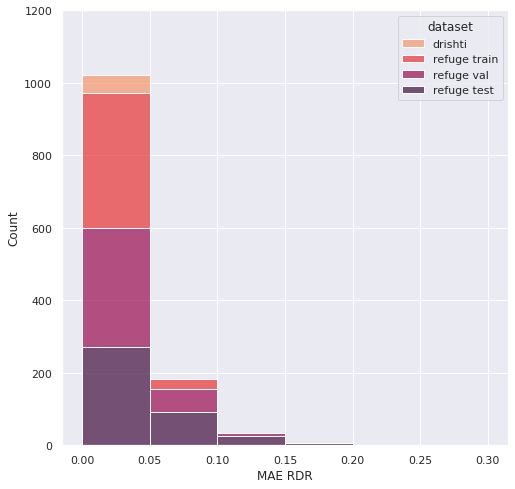

In [ ]:
f = plt.figure(figsize=(8,8))
bw = 0.05

sns.set_theme()
ax = f.add_subplot(1,1,1)
sns.histplot(data=df_feature_rim, ax=ax, stat="count", multiple="stack",
             x="RDR_mae", kde=False,
             palette="rocket_r", hue="dataset",
             binwidth=bw, binrange=(0, 0.3),
             element="bars", legend=True)
ax.set_ylim(0, 1200)
ax.set_xlabel("MAE RDR")
ax.set_ylabel("Count")

In [ ]:
bin = np.linspace(0.0, 0.3, num=7)

for i in range(len(bin) - 1):
  count = len(df_feature_rim.loc[(df_feature_rim["RDR_mae"] >= bin[i]) & (df_feature_rim["RDR_mae"] < bin[i+1])])
  print("{:.2f} - {:.2f}\t{}".format(bin[i], bin[i+1], count))

0.00 - 0.05	1023
0.05 - 0.10	182
0.10 - 0.15	35
0.15 - 0.20	7
0.20 - 0.25	0
0.25 - 0.30	1


In [ ]:
'''
Persebaran MAE RDR
Bin           RDR 
0.00 - 0.05	  1023
0.05 - 0.10	  182
0.10 - 0.15	  35
0.15 - 0.20 	7
0.20 - 0.25 	0
0.25 - 0.30	  1
'''

## Visualisasi RDR

In [ ]:
bin = np.linspace(0.0, 0.3, num=7)

n = 3

df_feature_rim1 = df_feature_rim.loc[(df_feature_rim["RDR_mae"] >= bin[n]) & (df_feature_rim["RDR_mae"] < bin[n+1])]
df_feature_rim1 = df_feature_rim1.sort_values("RDR_mae")
len(df_feature_rim1)

7

In [ ]:
ind = df_feature_rim1.index.tolist()
@interact(i=(0, len(df_feature_rim1)-1))
def show_patches_axes(i=0):
  ROI = cv2.imread(df_feature_rim1['path_img_loc'].iloc[i], 0)
  ROI = (resize(ROI, (550, 550), mode = 'constant', preserve_range = True))

  OD_fit = cv2.imread(df_feature_rim1['path_OD_fixed'].iloc[i], 0)
  OC_fit = cv2.imread(df_feature_rim1['path_OC_fixed'].iloc[i], 0)
  cOC = getCenter(OC_fit)
  rRim = df_feature_rim1['radRim'].iloc[i]
  rOD = df_feature_rim1['radOD'].iloc[i]
  angle = df_feature_rim1['angle'].iloc[i]

  OD_gt = cv2.imread(df_feature_rim1['path_OD_loc'].iloc[i], 0)
  OC_gt = cv2.imread(df_feature_rim1['path_OC_loc'].iloc[i], 0)
  cOC_gt = getCenter(OC_gt)
  rRim_gt = df_feature_rim1['radRim_gt'].iloc[i]
  rOD_gt = df_feature_rim1['radOD_gt'].iloc[i]
  angle_gt = df_feature_rim1['angle_gt'].iloc[i]

  plt.figure(figsize=(15, 15))
  plt.subplot(221),
  plt.imshow(ROI, cmap='gray')
  plt.title('Citra {}'.format(df_feature_rim1['file_name'].iloc[i]))
  plt.plot(cOC[0], cOC[1], 'o', color='red')
  plt.plot(rRim[0], rRim[1], color='red', lw=4)
  plt.contour(OD_fit, colors='royalblue')
  plt.contour(OC_fit, colors='royalblue')
  plt.text(20, 80, 'RDR: {:.3f}\n\nFScore OD: {:.3f}\nFScore OC: {:.3f}'.format(df_feature_rim1['RDR'].iloc[i],
                                                                                df_feature_rim1['Fscore_OD_fit'].iloc[i],
                                                                                df_feature_rim1['Fscore_OC_fit'].iloc[i]),
           size='small', color='w')
  plt.grid(False)

  plt.subplot(222),
  plt.imshow(ROI, cmap='gray')
  plt.title('GT {}'.format(df_feature_rim1['file_name'].iloc[i]))
  plt.plot(cOC_gt[0], cOC_gt[1], 'o', color='red')
  plt.plot(rRim_gt[0], rRim_gt[1], color='red', lw=4)
  plt.contour(OD_gt, colors='royalblue')
  plt.contour(OC_gt, colors='royalblue')
  plt.text(20, 50, 'RDR gt: {:.3f}\nRDR mae: {:.3f}'.format(df_feature_rim1['RDR_gt'].iloc[i],
                                                             df_feature_rim1['RDR_mae'].iloc[i]),
           size='small', color='w')
  plt.grid(False)

  plt.subplot(223),
  plt.imshow(ROI, cmap='gray')
  plt.plot(cOC[0], cOC[1], 'o', color='red')
  plt.plot(rOD[0], rOD[1], color='red', lw=4)
  plt.contour(OD_fit, colors='royalblue')
  plt.contour(OC_fit, colors='royalblue')
  plt.grid(False)

  plt.subplot(224),
  plt.imshow(ROI, cmap='gray')
  plt.plot(cOC_gt[0], cOC_gt[1], 'o', color='red')
  plt.plot(rOD_gt[0], rOD_gt[1], color='red', lw=4)
  plt.contour(OD_gt, colors='royalblue')
  plt.contour(OC_gt, colors='royalblue')
  plt.grid(False)

interactive(children=(IntSlider(value=0, description='i', max=6), Output()), _dom_classes=('widget-interact',)…

In [ ]:
df_feature_norm[['VCDR', 'HCDR', 'ACDR', 'VCDR_gt', 'HCDR_gt', 'ACDR_gt', 'VCDR_mae', 'HCDR_mae', 'ACDR_mae']].loc[df_feature_norm['file_name'] == 'T0013.jpg']

,VCDR,HCDR,ACDR,VCDR_gt,HCDR_gt,ACDR_gt,VCDR_mae,HCDR_mae,ACDR_mae
860,0.585284,0.573077,0.339376,0.613861,0.677419,0.413998,0.028577,0.104342,0.074622


### Langkah

(292, 217, 48298)
350.3355704697987


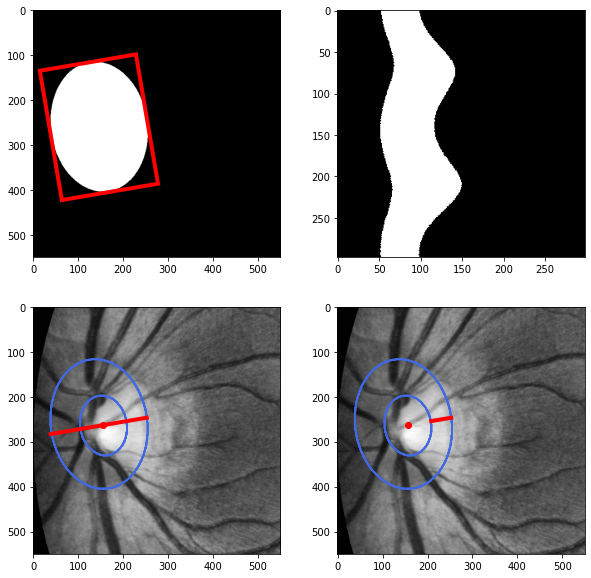

In [ ]:
# [1095, 834, 1087, 1035, 723]
# [285, 360, 764]

i = 285

ROI = cv2.imread(df['path_img_loc'].iloc[i], 0)
OD_fit = cv2.imread(df['path_OD_fixed'].iloc[i], 0)
OC_fit = cv2.imread(df['path_OC_fixed'].iloc[i], 0)
 
cOC = getCenter(OC_fit)
cOD = getCenter(OD_fit)
featOD = getFeature(OD_fit)
size = max(featOD[0], featOD[1]) + max(abs(cOD[0] - cOC[0]), abs(cOD[1] - cOC[1]))
polarOD = polarTransform(OD_fit, cOC, size)
polarOC = polarTransform(OC_fit, cOC, size)

rimWidth, r, a = getRim(polarOD, polarOC)
polarRim = cv2.subtract(polarOD, polarOC)

a_deg = a * 180/math.pi

ODcrop, _ = ekstrakROI(cOC, size, OD_fit)
_, featOD, _ = getOCAxes(ODcrop, a_deg)

rRim = getCartesian(r[0], a, cOC, rimWidth)
rOD = getCartesian(r[1], a, cOC, featOD[1] * (-1))

boxOD = cv2.boxPoints((cOD, tuple((featOD[1], featOD[0])), a_deg))

plt.figure(figsize=(10, 10))
plt.subplot(221),
plt.imshow(OD_fit, cmap='gray')
plt.gca().add_patch(Rectangle((boxOD[1]), featOD[1], featOD[0],
                               angle=a_deg, edgecolor='red',
                               facecolor='none', lw=4))
plt.grid(False)

plt.subplot(222),
plt.imshow(polarRim, cmap='gray')
plt.grid(False)

plt.subplot(223),
plt.imshow(ROI, cmap='gray')
plt.plot(cOC[0], cOC[1], 'o', color='red')
plt.plot(rOD[0], rOD[1], color='red', lw=4)
plt.contour(OD_fit, colors='royalblue')
plt.contour(OC_fit, colors='royalblue')
plt.grid(False)

plt.subplot(224),
plt.imshow(ROI, cmap='gray')
plt.plot(cOC[0], cOC[1], 'o', color='red')
plt.plot(rRim[0], rRim[1], color='red', lw=4)
plt.contour(OD_fit, colors='royalblue')
plt.contour(OC_fit, colors='royalblue')
plt.grid(False)